In [66]:
import uproot4
from matplotlib import pyplot as plt
from hist import Hist  
import hist
import awkward as ak
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import matplotlib.image as mpimg
import seaborn as sns
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
import keras
import tensorflow
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score
from sklearn.metrics import f1_score
from sklearn.metrics import f1_score
from sklearn.preprocessing import MinMaxScaler

## Loading mixed Dataset for model validation

In [67]:
# df_test = pd.read_csv("testDataAll_500k_30exp.csv")

In [68]:
# X_test = df_test.drop(columns='target')
# y_test = df_test['target']

In [69]:
# print(f"The shape of test data is {X_test.shape}")

# Pion  

###  File loading

In [70]:
file=uproot4.open("pion30mmGem.edm4hep.root")

tree= file["events"]

entries=tree.num_entries

print(f"Total entries is {entries}")

Total entries is 200000


In [71]:
pos_x= tree['ForwardTRDHits/ForwardTRDHits.position.x'].array()
pos_y= tree['ForwardTRDHits/ForwardTRDHits.position.y'].array()
pos_z= tree['ForwardTRDHits/ForwardTRDHits.position.z'].array()
ene= tree['ForwardTRDHits/ForwardTRDHits.EDep'].array()*(10**6) #to keV

flat_posX=ak.flatten(pos_x)
flat_posY=ak.flatten(pos_y)
flat_posZ=ak.flatten(pos_z)
flat_ene=ak.flatten(ene) 

In [72]:
data2={
    "position Z pion":flat_posZ,
    "energyDeposit_pion":flat_ene
    
}
df_pion=pd.DataFrame(data=data2)

### Feature generation and data cleaning

In [73]:
data_idx = df_pion.index[(df_pion['position Z pion']>=3510) & 
        (df_pion['energyDeposit_pion']>1000)].tolist()

In [74]:
#removing the defected points
df_pion=df_pion.drop(data_idx,axis=0)

In [75]:
# The bin points applies to both electrons and pins
bin_points=np.linspace(3510, 3540, 30, endpoint=True)
print(len(bin_points))
bin_points

30


array([3510.        , 3511.03448276, 3512.06896552, 3513.10344828,
       3514.13793103, 3515.17241379, 3516.20689655, 3517.24137931,
       3518.27586207, 3519.31034483, 3520.34482759, 3521.37931034,
       3522.4137931 , 3523.44827586, 3524.48275862, 3525.51724138,
       3526.55172414, 3527.5862069 , 3528.62068966, 3529.65517241,
       3530.68965517, 3531.72413793, 3532.75862069, 3533.79310345,
       3534.82758621, 3535.86206897, 3536.89655172, 3537.93103448,
       3538.96551724, 3540.        ])

In [76]:
#Creating array for positionsZ and energy depsoit according to the bins data points
itr=len(bin_points)
feature_pion=[]
for i in range(1,itr):
    temp_pos=(np.array(df_pion[(df_pion['position Z pion']>=bin_points[i-1]) & 
                                                    (df_pion['position Z pion']<=bin_points
                                                     [i])]['position Z pion']))
    temp_ene=(np.array(df_pion[(df_pion['position Z pion']>=bin_points[i-1]) & 
                                            (df_pion['position Z pion']<=bin_points
                                             [i])]['energyDeposit_pion']))
    feature_pion.append((temp_pos,temp_ene))
    
# [0][0] ---> position
# [1][1]-----> energy

In [77]:
feature_pion = np.array(feature_pion)

<ipython-input-77-71feffc5ddd5>:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  feature_pion = np.array(feature_pion)


In [78]:
print(f"Shape of feature pion is {feature_pion.shape}")

Shape of feature pion is (29, 2)


In [79]:
#Printing the shape of individual arrays
itr=feature_pion.shape[0]
for i in range(0,itr):
    print(f"Number:- {i} {feature_pion[i][0].shape}")

Number:- 0 (4804,)
Number:- 1 (4291,)
Number:- 2 (4017,)
Number:- 3 (3871,)
Number:- 4 (3853,)
Number:- 5 (3618,)
Number:- 6 (3526,)
Number:- 7 (3518,)
Number:- 8 (3249,)
Number:- 9 (3220,)
Number:- 10 (3115,)
Number:- 11 (3174,)
Number:- 12 (3077,)
Number:- 13 (2938,)
Number:- 14 (2912,)
Number:- 15 (2925,)
Number:- 16 (2907,)
Number:- 17 (2958,)
Number:- 18 (2802,)
Number:- 19 (2657,)
Number:- 20 (2845,)
Number:- 21 (2708,)
Number:- 22 (2703,)
Number:- 23 (2639,)
Number:- 24 (2594,)
Number:- 25 (2530,)
Number:- 26 (2640,)
Number:- 27 (2583,)
Number:- 28 (2579,)


In [80]:
# Randomly samplin the energy deposits according to the position Z
# Creating first column of the new data frame
smallest_len=2530
temp=np.random.choice(feature_pion[0][1],smallest_len)
df_pionBin = pd.DataFrame(data={'in0':temp})

for i in range(1,itr):
    df_pionBin[str("in"+str(i))]=np.random.choice(feature_pion[i][1],smallest_len)
    

In [81]:
#Generating equal number of truth data points
pion_truth=[]
for i in range(0,smallest_len):
    pion_truth.append(0)

#Adding the pion truth column
df_pionBin['target']=pion_truth
df_pionBin

,in0,in1,in2,in3,in4,in5,in6,in7,in8,in9,...,in20,in21,in22,in23,in24,in25,in26,in27,in28,target
0,6.471384,2.244250,2.752055,1.142047,19.701662,8.743987,1.754663,9.929188,2.746885,1.027730,...,1.762712,6.942644,2.015876,1.459806,1.940457,1.402185,1.394027,3.576089,5.189058,0
1,1.449779,1.154144,3.655569,13.758029,5.381762,1.184633,2.671839,7.546498,2.085563,1.098704,...,7.347216,8.441882,23.915552,3.637949,1.027290,3.500812,1.529030,2.912396,2.686222,0
2,14.103167,1.668879,2.409905,3.438835,1.294432,1.458165,6.312615,1.044867,1.884717,1.920816,...,1.345755,1.280264,1.045259,1.186525,1.708049,1.166042,1.388021,1.225349,4.410449,0
3,43.633139,1.986772,1.128156,2.568506,1.338208,1.244336,9.699119,4.819314,2.138514,6.230587,...,18.775028,7.528972,1.862461,3.747453,4.053209,1.084483,1.253709,1.123334,5.447934,0
4,1.154440,4.051877,1.460459,1.333732,2.232161,1.588309,5.744071,2.525429,6.551503,1.109985,...,6.113165,1.000612,3.326439,1.738286,3.298439,2.748093,4.604361,1.171999,1.083598,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2525,1.281692,1.452979,1.333335,12.248724,1.012396,3.438146,1.280306,3.385248,3.907522,1.774157,...,2.260722,3.337889,20.163643,12.519456,1.075721,1.082024,1.705762,2.180315,1.348664,0
2526,2.365205,1.624718,2.121024,4.422407,4.178382,1.994367,1.231936,1.683951,1.246727,1.096337,...,1.569221,10.910481,1.530850,1.771224,1.894673,1.144706,2.733251,16.019852,8.661417,0
2527,7.806934,7.350956,2.708142,9.138442,3.242947,1.524759,4.341005,1.037252,2.340873,1.574057,...,1.007704,20.770933,1.527044,1.897426,9.791263,1.438535,2.788505,1.113529,8.274163,0
2528,1.082388,2.088608,4.835772,2.027613,7.823048,5.711072,8.092815,22.510201,6.594293,2.719781,...,2.049758,10.962074,2.961351,1.745950,1.040520,1.116142,3.827451,1.301631,1.773457,0


# Electron 

In [84]:
file2=uproot4.open("ele30mm.edm4hep.root")

tree2= file2["events"]

entries2=tree2.num_entries

print(f"Total entries is {entries2}")

Total entries is 200000


In [85]:
pos_xE= tree2['ForwardTRDHits/ForwardTRDHits.position.x'].array()
pos_yE= tree2['ForwardTRDHits/ForwardTRDHits.position.y'].array()
pos_zE= tree2['ForwardTRDHits/ForwardTRDHits.position.z'].array()
ene_E= tree2['ForwardTRDHits/ForwardTRDHits.EDep'].array()*(10**6) #to keV

flat_posXE=ak.flatten(pos_xE)
flat_posYE=ak.flatten(pos_yE)
flat_posZE=ak.flatten(pos_zE)
flat_eneE=ak.flatten(ene_E) 

In [86]:
data1={
    "position Z ele":flat_posZE,
    "energyDeposit_ele":flat_eneE
    
}
df_ele=pd.DataFrame(data=data1)

In [87]:
#Creating array for positionsZ and energy depsoit according to the bins data points
itr=len(bin_points)
feature_ele=[]
for i in range(1,itr):
    temp_posE=(np.array(df_ele[(df_ele['position Z ele']>=bin_points[i-1]) & 
                                                    (df_ele['position Z ele']<=bin_points
                                                     [i])]['position Z ele']))
    temp_eneE=(np.array(df_ele[(df_ele['position Z ele']>=bin_points[i-1]) & 
                                            (df_ele['position Z ele']<=bin_points
                                             [i])]['energyDeposit_ele']))
    feature_ele.append((temp_posE,temp_eneE))
    
# [0][0] ---> position
# [1][1]-----> energy

In [88]:
feature_ele = np.array(feature_ele)

<ipython-input-88-04bebac0078c>:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  feature_ele = np.array(feature_ele)


In [89]:
print(f"Shape of feature ele is {feature_ele.shape}")

Shape of feature ele is (29, 2)


In [90]:
#Printing the shape of individual arrays
itr=feature_ele.shape[0]
for i in range(0,itr):
    print(f"Number:- {i} {feature_ele[i][0].shape}")

Number:- 0 (34786,)
Number:- 1 (28332,)
Number:- 2 (24233,)
Number:- 3 (20873,)
Number:- 4 (17949,)
Number:- 5 (15901,)
Number:- 6 (14472,)
Number:- 7 (13329,)
Number:- 8 (12612,)
Number:- 9 (11803,)
Number:- 10 (11489,)
Number:- 11 (11049,)
Number:- 12 (10820,)
Number:- 13 (10654,)
Number:- 14 (10290,)
Number:- 15 (10316,)
Number:- 16 (10085,)
Number:- 17 (10115,)
Number:- 18 (9785,)
Number:- 19 (9745,)
Number:- 20 (9958,)
Number:- 21 (9956,)
Number:- 22 (9688,)
Number:- 23 (9733,)
Number:- 24 (9660,)
Number:- 25 (9349,)
Number:- 26 (9586,)
Number:- 27 (9269,)
Number:- 28 (9637,)


In [91]:
# Randomly samplin the energy deposits according to the position Z
# Creating first column of the new data frame
smallest_len=9269
tempE=np.random.choice(feature_ele[0][1],smallest_len)
df_eleBin = pd.DataFrame(data={'in0':tempE})

for i in range(1,itr):
    df_eleBin[str("in"+str(i))]=np.random.choice(feature_ele[i][1],smallest_len)
    

In [92]:
#Generating equal number of truth data points
ele_truth=[]
for i in range(0,smallest_len):
    ele_truth.append(1)

#Adding the pion truth column
df_eleBin['target']=ele_truth
df_eleBin

,in0,in1,in2,in3,in4,in5,in6,in7,in8,in9,...,in20,in21,in22,in23,in24,in25,in26,in27,in28,target
0,6.262922,11.568588,9.816002,8.277820,10.271878,7.189833,5.094539,1.110241,9.607146,1.181037,...,5.167653,2.025500,1.651684,1.577069,1.092206,2.744162,1.060495,1.986515,1.665468,1
1,12.517183,3.699769,12.883152,5.680608,2.129372,11.041831,1.870922,1.636103,1.735877,3.544026,...,1.031911,3.048317,12.570973,1.084397,1.758054,1.574019,8.050371,3.624501,3.160499,1
2,5.027314,12.890419,14.643698,4.752800,2.263032,1.099057,18.980163,1.021540,10.289556,2.418181,...,8.673896,3.962229,3.228110,1.052217,1.511392,1.205363,1.019595,2.846630,1.141398,1
3,1.487078,15.137609,12.811746,4.057699,5.080855,9.838061,2.552044,4.491187,1.037641,4.693893,...,4.287554,10.572479,4.721035,3.429593,1.525455,4.981940,5.070576,7.803318,9.727953,1
4,5.884614,9.649805,8.440809,1.230395,1.346793,9.960260,2.002605,15.660647,7.331110,1.232858,...,1.004618,1.633203,2.184180,1.023471,1.977080,1.045109,1.207582,2.812953,3.060607,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9264,16.151342,12.330885,12.508626,11.876066,11.906844,6.349202,9.725137,2.138952,3.436947,19.113702,...,1.707964,1.085635,1.520900,1.244185,4.355986,2.391132,4.261324,1.031169,14.158544,1
9265,8.593668,1.046783,13.121999,12.442451,1.689101,9.513883,2.505628,7.666770,1.254221,5.538728,...,3.074093,44.357024,4.089458,31.827589,2.387110,1.745008,1.269354,1.988024,2.644835,1
9266,10.853662,20.188892,17.255978,2.084837,14.272087,7.864694,3.694116,3.530025,34.556000,5.023234,...,3.444293,10.029701,1.017958,1.892318,1.222324,1.132172,1.124779,3.401483,1.960808,1
9267,2.845218,2.115265,2.051722,6.651545,6.937373,12.077046,1.059717,3.057254,1.330937,1.476441,...,6.155024,1.121775,2.706571,2.486011,1.609925,15.052661,1.090092,16.402546,4.184175,1


# Merging electrons and pions for training

In [93]:
df_eleBin

,in0,in1,in2,in3,in4,in5,in6,in7,in8,in9,...,in20,in21,in22,in23,in24,in25,in26,in27,in28,target
0,6.262922,11.568588,9.816002,8.277820,10.271878,7.189833,5.094539,1.110241,9.607146,1.181037,...,5.167653,2.025500,1.651684,1.577069,1.092206,2.744162,1.060495,1.986515,1.665468,1
1,12.517183,3.699769,12.883152,5.680608,2.129372,11.041831,1.870922,1.636103,1.735877,3.544026,...,1.031911,3.048317,12.570973,1.084397,1.758054,1.574019,8.050371,3.624501,3.160499,1
2,5.027314,12.890419,14.643698,4.752800,2.263032,1.099057,18.980163,1.021540,10.289556,2.418181,...,8.673896,3.962229,3.228110,1.052217,1.511392,1.205363,1.019595,2.846630,1.141398,1
3,1.487078,15.137609,12.811746,4.057699,5.080855,9.838061,2.552044,4.491187,1.037641,4.693893,...,4.287554,10.572479,4.721035,3.429593,1.525455,4.981940,5.070576,7.803318,9.727953,1
4,5.884614,9.649805,8.440809,1.230395,1.346793,9.960260,2.002605,15.660647,7.331110,1.232858,...,1.004618,1.633203,2.184180,1.023471,1.977080,1.045109,1.207582,2.812953,3.060607,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9264,16.151342,12.330885,12.508626,11.876066,11.906844,6.349202,9.725137,2.138952,3.436947,19.113702,...,1.707964,1.085635,1.520900,1.244185,4.355986,2.391132,4.261324,1.031169,14.158544,1
9265,8.593668,1.046783,13.121999,12.442451,1.689101,9.513883,2.505628,7.666770,1.254221,5.538728,...,3.074093,44.357024,4.089458,31.827589,2.387110,1.745008,1.269354,1.988024,2.644835,1
9266,10.853662,20.188892,17.255978,2.084837,14.272087,7.864694,3.694116,3.530025,34.556000,5.023234,...,3.444293,10.029701,1.017958,1.892318,1.222324,1.132172,1.124779,3.401483,1.960808,1
9267,2.845218,2.115265,2.051722,6.651545,6.937373,12.077046,1.059717,3.057254,1.330937,1.476441,...,6.155024,1.121775,2.706571,2.486011,1.609925,15.052661,1.090092,16.402546,4.184175,1


In [94]:
#Merging electrons and pions
df_trainData = pd.concat([df_eleBin,df_pionBin],ignore_index=True)
df_trainData = df_trainData.sample(frac=1,random_state=32)

In [95]:
df_trainData.head(5)

,in0,in1,in2,in3,in4,in5,in6,in7,in8,in9,...,in20,in21,in22,in23,in24,in25,in26,in27,in28,target
1482,2.291025,4.070556,17.031578,2.385039,1.163008,8.298830,7.550301,2.316136,6.868140,4.263015,...,1.329258,3.049706,1.390965,2.275199,1.790093,5.413238,3.452246,1.607963,1.678022,1
3228,21.516895,6.085754,9.455454,10.521913,1.758941,2.325241,1.080671,3.666227,1.231649,2.627414,...,5.189607,11.490225,2.552481,1.712145,1.197397,3.197811,1.635554,6.779205,1.085308,1
6635,9.596698,13.723632,9.418552,2.036313,5.416900,1.029529,1.536000,1.659218,10.651306,3.880275,...,3.996750,1.220469,1.303998,1.194224,1.062439,1.050709,1.410888,3.313159,6.661760,1
3921,10.814733,2.427322,11.508097,1.048433,10.345317,1.590774,3.414500,9.387657,1.413503,9.849658,...,2.944826,2.277338,11.250781,1.959890,3.112990,1.470498,2.037700,1.210707,2.694405,1
11537,4.402209,7.490688,1.037194,5.524058,4.358868,3.212755,5.428860,2.837595,2.287366,3.430954,...,1.105075,1.166981,1.326689,1.669226,1.927022,1.018123,3.157541,1.467708,1.312185,0


In [96]:
df_trainData['target'].value_counts()

1    9269
0    2530
Name: target, dtype: int64

In [97]:
#sampling the target=1 columns
df_trainNew = df_trainData[df_trainData['target']
             ==1].sample(n=df_trainData
                         ['target'].value_counts().values[1],random_state=32)

In [98]:
df_trainTemp = df_trainData[df_trainData['target']
             ==0]

#merging
df_trainData = pd.concat([df_trainNew,df_trainTemp],axis=0)
df_trainData = df_trainData.sample(frac=1,random_state=32)
df_trainData.shape

(5060, 30)

In [99]:
#creating independent and dependent features
X = df_trainData.drop(columns="target")
y = df_trainData['target']

y.value_counts()

1    2530
0    2530
Name: target, dtype: int64

In [100]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=32)

In [101]:
print(f"The shape of X train is {X_train.shape}")
print(f"The shape of X test is {X_test.shape}")

The shape of X train is (4048, 29)
The shape of X test is (1012, 29)


In [102]:
# Scaling the training features to the range [0,1]
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)


In [103]:
#scaling the test features
X_test_scaled = scaler.transform(X_test)
X_test_scaled

array([[9.44666801e-03, 6.19461255e-02, 7.55681105e-02, ...,
        1.99351597e-03, 1.10911127e-01, 4.44316048e-02],
       [1.36130995e-02, 1.29567607e-01, 6.78820513e-02, ...,
        3.48668176e-03, 7.78002225e-01, 1.19243758e-01],
       [1.97069346e-02, 1.55821391e-04, 6.09018139e-03, ...,
        1.80649376e-03, 5.37404375e-03, 4.64488549e-02],
       ...,
       [1.43683375e-04, 2.86611678e-03, 2.23813158e-02, ...,
        3.48707254e-03, 4.44460524e-03, 6.61165579e-02],
       [5.46500384e-04, 2.47670431e-03, 3.18748938e-04, ...,
        2.59738858e-01, 9.33225482e-03, 4.43935983e-02],
       [5.32770869e-03, 1.53984938e-04, 2.59776019e-01, ...,
        7.64653434e-03, 8.96355080e-02, 1.01159578e-02]])

### Testing Classical models

In [104]:
def plotPredict(predictions,y_test):
    conf_matrix = confusion_matrix(y_test,predictions)
    sns.heatmap(data=conf_matrix,annot=True,fmt='d')
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    print(classification_report(y_test,predictions))


##### Random Forest

In [105]:
model_rf = RandomForestClassifier(n_estimators=500)
model_rf.fit(X_train,y_train)

RandomForestClassifier(n_estimators=500)

In [106]:
predictions_rf = model_rf.predict(X_test)

              precision    recall  f1-score   support

           0       0.84      0.86      0.85       506
           1       0.86      0.84      0.85       506

    accuracy                           0.85      1012
   macro avg       0.85      0.85      0.85      1012
weighted avg       0.85      0.85      0.85      1012



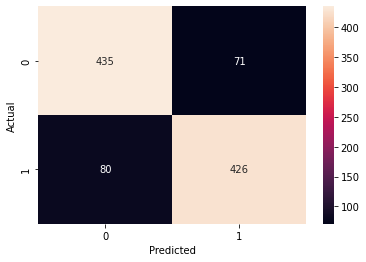

In [107]:
plotPredict(predictions_rf,y_test)

#####  Decison tree

In [108]:
model_dt=DecisionTreeClassifier()
model_dt.fit(X_train_scaled,y_train)

DecisionTreeClassifier()

In [109]:
predictions_dt = model_dt.predict(X_test_scaled)

              precision    recall  f1-score   support

           0       0.77      0.77      0.77       506
           1       0.77      0.76      0.77       506

    accuracy                           0.77      1012
   macro avg       0.77      0.77      0.77      1012
weighted avg       0.77      0.77      0.77      1012



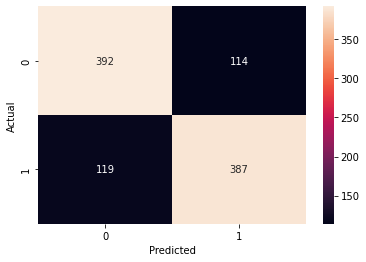

In [110]:
plotPredict(predictions_dt,y_test)

##### Neural Network 

In [111]:
# #84-85%

# model_Snn = keras.Sequential()
# model_Snn.add(keras.layers.Dense(units=500,input_dim=69,activation="relu"))
# model_Snn.add(keras.layers.BatchNormalization())
# model_Snn.add(keras.layers.Dropout(0.7))
# model_Snn.add(keras.layers.Dense(units=300,activation="relu"))
# model_Snn.add(keras.layers.BatchNormalization())
# model_Snn.add(keras.layers.Dropout(0.7))
# model_Snn.add(keras.layers.Dense(units=200,activation="relu"))
# model_Snn.add(keras.layers.BatchNormalization())
# model_Snn.add(keras.layers.Dropout(0.5))
# model_Snn.add(keras.layers.Dense(units=100,activation="relu"))
# model_Snn.add(keras.layers.BatchNormalization())
# model_Snn.add(keras.layers.Dense(units=100,activation="relu"))
# model_Snn.add(keras.layers.BatchNormalization())
# model_Snn.add(keras.layers.Dense(units=1,activation="sigmoid"))

# model_Snn.summary()

In [112]:
#84-85%

model_Snn = keras.Sequential()
model_Snn.add(keras.layers.Dense(units=500,input_dim=29,activation="leaky_relu"))
model_Snn.add(keras.layers.BatchNormalization())
model_Snn.add(keras.layers.Dropout(0.7))
model_Snn.add(keras.layers.Dense(units=300,activation="relu"))
model_Snn.add(keras.layers.BatchNormalization())
model_Snn.add(keras.layers.Dropout(0.7))
model_Snn.add(keras.layers.Dense(units=200,activation="relu"))
model_Snn.add(keras.layers.Dense(units=1,activation="sigmoid"))

model_Snn.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 500)               15000     
                                                                 
 batch_normalization (BatchN  (None, 500)              2000      
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 500)               0         
                                                                 
 dense_1 (Dense)             (None, 300)               150300    
                                                                 
 batch_normalization_1 (Batc  (None, 300)              1200      
 hNormalization)                                                 
                                                                 
 dropout_1 (Dropout)         (None, 300)               0

In [113]:
model_Snn.compile(optimizer="adam",loss="binary_crossentropy",metrics=['accuracy'])

history=model_Snn.fit(x=X_train_scaled,y=y_train,epochs=100,
              validation_data=(X_test_scaled,y_test))

Epoch 1/100
127/127 [==============================] - 2s 8ms/step - loss: 0.7415 - accuracy: 0.6282 - val_loss: 0.6897 - val_accuracy: 0.5020
Epoch 2/100
127/127 [==============================] - 1s 6ms/step - loss: 0.6540 - accuracy: 0.6917 - val_loss: 0.7179 - val_accuracy: 0.5010
Epoch 3/100
127/127 [==============================] - 1s 5ms/step - loss: 0.5885 - accuracy: 0.7125 - val_loss: 0.8066 - val_accuracy: 0.5049
Epoch 4/100
127/127 [==============================] - 1s 7ms/step - loss: 0.5797 - accuracy: 0.7236 - val_loss: 0.6475 - val_accuracy: 0.6453
Epoch 5/100
127/127 [==============================] - 1s 6ms/step - loss: 0.5673 - accuracy: 0.7216 - val_loss: 0.5810 - val_accuracy: 0.7075
Epoch 6/100
127/127 [==============================] - 1s 6ms/step - loss: 0.5471 - accuracy: 0.7352 - val_loss: 0.5156 - val_accuracy: 0.7510
Epoch 7/100
127/127 [==============================] - 1s 5ms/step - loss: 0.5288 - accuracy: 0.7500 - val_loss: 0.5075 - val_accuracy: 0.7579

Epoch 58/100
127/127 [==============================] - 1s 6ms/step - loss: 0.4000 - accuracy: 0.8263 - val_loss: 0.4226 - val_accuracy: 0.8152
Epoch 59/100
127/127 [==============================] - 1s 6ms/step - loss: 0.4004 - accuracy: 0.8187 - val_loss: 0.4100 - val_accuracy: 0.8202
Epoch 60/100
127/127 [==============================] - 1s 6ms/step - loss: 0.4019 - accuracy: 0.8182 - val_loss: 0.4105 - val_accuracy: 0.8211
Epoch 61/100
127/127 [==============================] - 1s 6ms/step - loss: 0.3926 - accuracy: 0.8293 - val_loss: 0.4157 - val_accuracy: 0.8132
Epoch 62/100
127/127 [==============================] - 1s 6ms/step - loss: 0.3985 - accuracy: 0.8216 - val_loss: 0.4098 - val_accuracy: 0.8182
Epoch 63/100
127/127 [==============================] - 1s 6ms/step - loss: 0.3985 - accuracy: 0.8211 - val_loss: 0.4130 - val_accuracy: 0.8103
Epoch 64/100
127/127 [==============================] - 1s 6ms/step - loss: 0.3871 - accuracy: 0.8318 - val_loss: 0.4021 - val_accuracy:

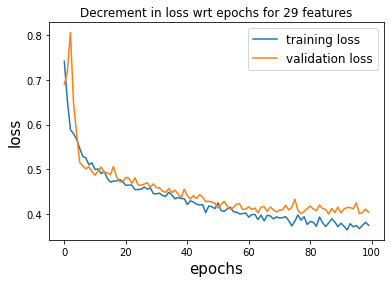

In [114]:
#Plotting the losses
loss=history.history['loss']
val_loss=history.history['val_loss']
index=np.arange(100)
sns.lineplot(x=index,y=loss)
sns.lineplot(x=index,y=val_loss)
plt.ylabel('loss',fontsize=15)
plt.xlabel('epochs',fontsize=15)
plt.title('Decrement in loss wrt epochs for 29 features')
plt.legend(['training loss','validation loss'],fontsize='large')
plt.show()

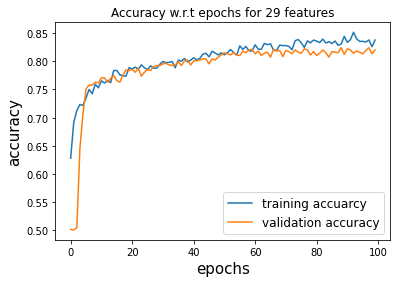

In [115]:
#Plotting the accuracy
loss=history.history['accuracy']
val_loss=history.history['val_accuracy']
index=np.arange(100)
sns.lineplot(x=index,y=loss)
sns.lineplot(x=index,y=val_loss)
plt.ylabel('accuracy',fontsize=15)
plt.xlabel('epochs',fontsize=15)
plt.title('Accuracy w.r.t epochs for 29 features')
plt.legend(['training accuarcy','validation accuracy'],fontsize='large')
plt.show()

In [116]:
predictions_snn=model_Snn.predict(X_test_scaled)

In [142]:
threshold_limit =0.5151
predictions_snn2=np.where(predictions_snn>threshold_limit,1,0)

              precision    recall  f1-score   support

           0       0.82      0.84      0.83       506
           1       0.83      0.81      0.82       506

    accuracy                           0.83      1012
   macro avg       0.83      0.83      0.83      1012
weighted avg       0.83      0.83      0.83      1012



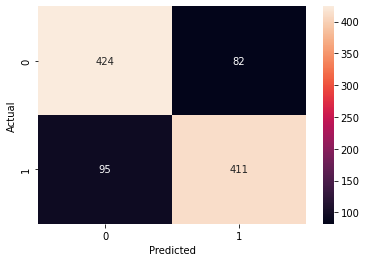

In [143]:
plotPredict(predictions_snn2,y_test)

In [144]:
##saving the model

model_Snn.save("NN_model29bins.h5")

In [145]:
# ##loading the model
# model_Snn = keras.models.load_model("NN_78Percent.h5")

In [146]:
# predictions_Snn = model_Snn.predict(X_test_scaled)

In [147]:
predictionsSnn_edited = []
for i in range(0,len(predictions_snn)):
    predictionsSnn_edited.append(predictions_snn[i][0])

In [148]:
data = {
    "predictions":predictionsSnn_edited,
    "y_truth":y_test
}
df_plot=pd.DataFrame(data=data)
df_plot

,predictions,y_truth
7510,0.855127,1
9065,0.989934,1
11550,0.366007,0
10015,0.418624,0
553,0.988035,1
...,...,...
7590,0.969639,1
10964,0.276017,0
11010,0.061391,0
9808,0.256367,0


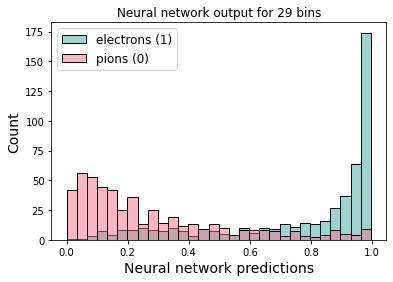

In [149]:
#plotting the graph
plt.figure(figsize=(6,4))
sns.histplot(df_plot,x="predictions",hue="y_truth",bins=30,palette=sns.color_palette("husl", 2))
plt.xlabel("Neural network predictions",fontsize=14)
plt.ylabel("Count",fontsize=14)
plt.title("Neural network output for 29 bins")
plt.legend(["electrons (1)","pions (0)"],fontsize='large')
plt.show()

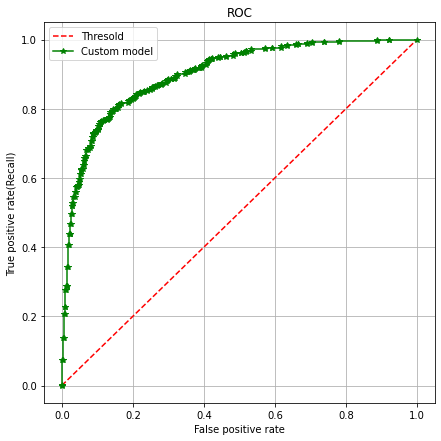

In [150]:
from sklearn.metrics import roc_curve
fpr2, tpr2, thresholds2=roc_curve(y_test,predictionsSnn_edited)
plt.figure(figsize=(7,7))
plt.plot([0, 1], [0, 1], '--',color='red',label='Thresold')
plt.plot(fpr2, tpr2,color='green',label='Custom model',marker="*")
plt.ylabel('True positive rate(Recall)')
plt.xlabel('False positive rate')
plt.title('ROC')
plt.grid()
plt.legend()
plt.show()


In [151]:
#rejection 
# how many pion falls inthe region greater than the threshold value with respect to the
# total pions 
pion_rejected = len(df_plot[(df_plot['predictions']>threshold_limit) & (df_plot['y_truth']==0)])
total_pion = len(df_plot[df_plot['y_truth']==0])
rejection_ratio = pion_rejected/total_pion 
print(rejection_ratio)

0.16205533596837945


In [152]:
#finding best threshold
thresholds_arr = np.linspace(0,1,100)
f1Arr=[]
for i in range(0,len(thresholds_arr)):
    temp = np.where(predictions_snn>thresholds_arr[i],1,0)
    f1Arr.append(f1_score(temp,y_test))
print(f"value : {max(f1Arr)}, index {np.argmax(f1Arr)}")

value : 0.8228228228228227, index 51


In [153]:
thresholds_arr[51]

0.5151515151515152